# Анализ предпочтений покупателей интернет-магазина 

В проекте представлена информация по продажам интернет-магазина товаров для дома. <br>
<br>
<b>Задачи проекта:</b> <br>
- анализ показателей продаж интернет-магазина<br>
- сегментация покупателей магазина <br>
- проверка гипотез о различном профиле потребления у сегментов <br>
- подготовка рекомендаций по маркетинговым активностям для сегментов <br>

<b>Содержание проекта:</b><br>
1. Предобработка<br>
2. Анализ данных<br>
3. Сегментация покупателей<br> 
4. Проверка гипотез о различиях сегментов <br>
5. Выявление предпочтений сегментов <br>
5. Общий вывод<br>

### Предобработка

In [1]:
# загрузка необходимых библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot
pd.set_option('display.max_colwidth', None)

<b>Описание столбцов датасета:</b> <br>
- date — дата заказа<br>
- customer_id — идентификатор покупателя<br>
- order_id — идентификатор заказа<br>
- product — наименование товара<br>
- quantity — количество товара в заказе<br>
- price — цена товара<br>
- category - категория товара

In [2]:
# загрузка датасета
data = pd.read_csv('data.csv')
data = data.drop(columns='Unnamed: 0')
display(data.head(1))
data.shape

,date,customer_id,order_id,product,quantity,price,category
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,растения


(5573, 7)

In [3]:
# изучение типов данных
#data.info()
# проверка на дубликаты 
#print('Кол-во дубликатов:',df.duplicated().sum())

In [4]:
# перевод даты в формат datetime
data['date'] = data['date'].map(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d %H:%M:%S'))

In [5]:
# добавление отдельных столбцов для анализа дат: день без времени / год+месяц
data['day'] = data['date'].dt.date
data['year_month'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m')
# добавление столбца с общей суммой стоимости товаров в заказе 
data['total_price'] = data['quantity'] * data['price']

In [6]:
display(data.head(1))

,date,customer_id,order_id,product,quantity,price,category,day,year_month,total_price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,растения,2018-10-01,2018-10,142.0


<div style="border:solid lightblue 2px; padding: 5px">
<b>Вывод по разделу №1:</b> <br>
Проведена предобработка датасета: <br>
- изменены типы данных <br>
- проведена проверка датасета на явные дубликаты: не выявлено  <br>
В датасет были добавлены дополнительные столбцы: <br>
- total_price - общая стоимость товаров в заказе (кол-во * стоимость единицы товара)<br>
- day - день заказа (без времени) <br>
- year_month - год и месяц заказа 

### Анализ данных

#### Анализ общих показателей

In [7]:
# агрегация данных за период: выручка / кол-во товаров / кол-во заказов / кол-во клиентов + средние показатели
print('Данные за весь период:')
print('Выручка, руб.',round(data['total_price'].sum(),2))
print('Кол-во проданных товаров, шт.',data['quantity'].sum())
print('Кол-во заказов (уникальных):',data['order_id'].nunique())
print('Кол-во покупателей (уникальных):',data['customer_id'].nunique())
print('Общее кол-во товаров в магазине (уникальных):',data['product'].nunique())
print('')
print('Средняя цена товара, руб.:', round(data['total_price'].sum() / data['quantity'].sum(),2))
print('Средняя стоимость заказа, руб.:', round(data['total_price'].sum() / data['order_id'].nunique(),2))
print('Средний доход с покупателя, руб.:', round(data['total_price'].sum() / data['customer_id'].nunique(),2))
print('Среднее кол-во товаров в заказе:', round(data['quantity'].sum() / data['order_id'].nunique(),2))
print('Среднее кол-во товаров на покупателя:', round(data['quantity'].sum() / data['customer_id'].nunique(),2))

Данные за весь период:
Выручка, руб. 4620711.42
Кол-во проданных товаров, шт. 14431
Кол-во заказов (уникальных): 3519
Кол-во покупателей (уникальных): 2429
Общее кол-во товаров в магазине (уникальных): 2338

Средняя цена товара, руб.: 320.19
Средняя стоимость заказа, руб.: 1313.08
Средний доход с покупателя, руб.: 1902.31
Среднее кол-во товаров в заказе: 4.1
Среднее кол-во товаров на покупателя: 5.94


<b>Выводы:</b> <br>
На основании данных за весь период можно сделать выводы: <br>
- выручка за 16 месяцев составила более 4,5 млн. рублей и было продано 14,3 тыс. товаров <br>
- средняя стоимость заказа составила 1643 руб. и в заказе в среднем были 5 товаров <br>
- каждый покупатель в среднем потратил 1889 руб. и купил в среднем около 6 товаров <br>

<b>/ Анализ показателей в динамике</b>

In [8]:
# группировка данных по месяцам 
total_by_month = data.groupby('year_month').agg(
    {'customer_id':'nunique','order_id':'nunique','quantity':'sum','total_price':'sum'})
total_by_month.columns = ['unique_customers','orders','total_quantity','total_revenue' ]
total_by_month['total_revenue'] = round(total_by_month['total_revenue'],2)
# расчет средней стоимости заказа
total_by_month['order_avg_revenue'] = round(total_by_month['total_revenue'] / total_by_month['orders'],3)
#display(total_by_month)

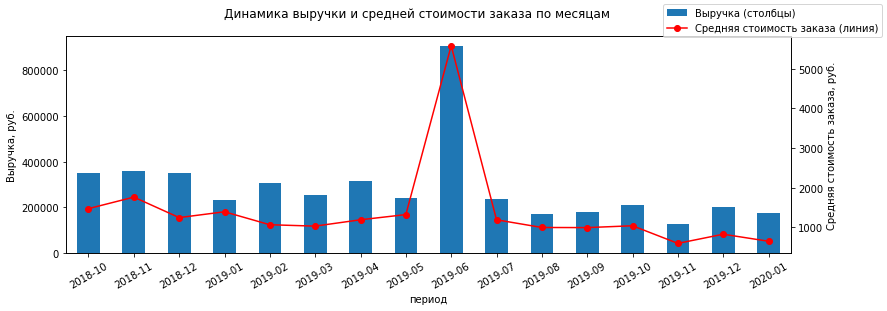

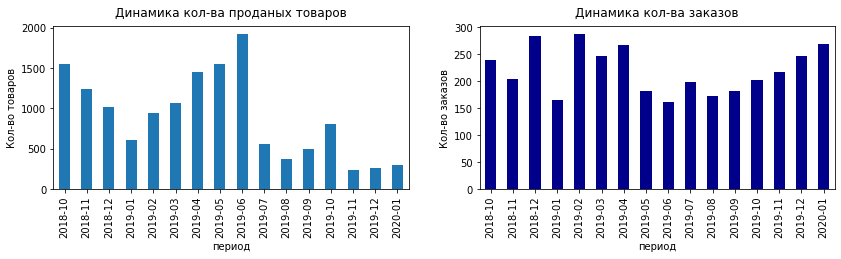

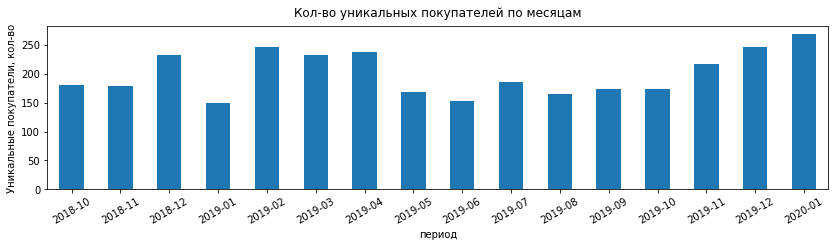

In [9]:
# визуализация данных по динамике выручки и средней стоимости заказа
fig, ax1 = plt.subplots(figsize=(13,4)) 
ax2 = ax1.twinx() 
total_by_month['total_revenue'].plot(kind = 'bar', ax = ax1)  
total_by_month['order_avg_revenue'].plot(kind = 'line',marker = 'o', color = 'red',ax = ax2)
ax1.xaxis.set_tick_params(rotation=30)
fig.suptitle('Динамика выручки и средней стоимости заказа по месяцам')
ax1.set_xlabel('период')
ax1.set_ylabel('Выручка, руб.')
ax2.set_ylabel('Средняя стоимость заказа, руб.')
fig.legend(['Выручка (столбцы)','Средняя стоимость заказа (линия)'],loc='upper right')
plt.show()
#визуализация данных по динамике количества проданных товаров и кол-ва закзаов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,3))
total_by_month['total_quantity'].plot(kind = 'bar', ax = ax1)
total_by_month['orders'].plot(kind = 'bar', color = 'darkblue', ax = ax2)
ax1.set_title('Динамика кол-ва проданых товаров', y = 1.02)
ax1.set_xlabel('период')
ax1.set_ylabel('Кол-во товаров')
ax2.set_title('Динамика кол-ва заказов', y = 1.02)
ax2.set_xlabel('период')
ax2.set_ylabel('Кол-во заказов')
plt.show()
# визуализация данных по динамике количества уникальных посетителей
total_by_month['unique_customers'].plot(kind = 'bar',figsize=(14, 3), legend = False)
plt.title('Кол-во уникальных покупателей по месяцам',y=1.02)
plt.xlabel('период')
plt.ylabel('Уникальные покупатели, кол-во')
plt.xticks(rotation=30)
plt.show()

<b>Выводы:</b> <br>
Анализ динамики продаж показал, что: <br>
- в 2018 году ежемесячная выручка выше, чем в те же месяцы 2019 года => наблюдается снижение выручки магазина<br>
- наблюдается резкий всплеск выручки и средней стоимости заказа в июне 2019 года, при этм кол-во заказов в этот месяц ниже других месяцев<br>
- кол-во проданных товаров резко снижается после июня 2019 года, при этом кол-во заказов не снижается и растет => в заказе становится меньше товаров с июля 2019 года <br>
- ежемесячное кол-во уникальных покупателей сохраняется на протяжении периода практически на постоянном уровне (нет всплесков) <br>

Кол-во клиентов с одним заказом: 1545
Кол-во клиентов с несколькими заказами: 884
Доля клиентов с повторными заказами от всех клиентов: 0.364


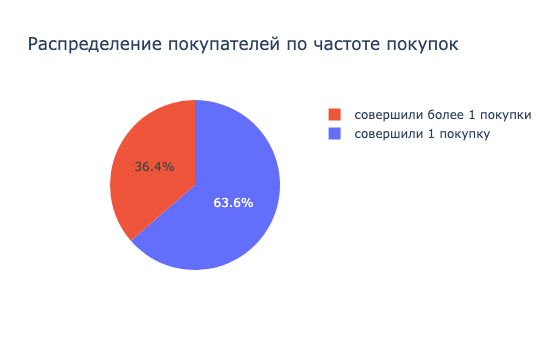

In [10]:
# анализ повторных покупок
customers_orders = data.groupby('customer_id').agg({'order_id':'nunique'}).reset_index()
one_purchase = customers_orders[customers_orders['order_id'] == 1]['customer_id'].nunique()
multiple_purchases = customers_orders[customers_orders['order_id'] > 1]['customer_id'].nunique()
print('Кол-во клиентов с одним заказом:',one_purchase )
print('Кол-во клиентов с несколькими заказами:', multiple_purchases)
print('Доля клиентов с повторными заказами от всех клиентов:', round(multiple_purchases/ customers_orders['customer_id'].nunique(),3))
# визуализация распределения покупателей по частоте покупки
fig = go.Figure(
    data=[go.Pie(labels=['совершили 1 покупку','совершили более 1 покупки'], 
                 values=[one_purchase,multiple_purchases])])
fig.update_layout(title='Распределение покупателей по частоте покупок',
                  width=550, height=350,
                  legend_traceorder="reversed")
fig.show(renderer='png', width = 550, height = 350) 

<b>Выводы:</b> <br>
Повторные покупки совершают лишь 6,5% покупателей (93,5% покупателей сделали 1 заказ).

####  Анализ стоимости товаров

Минимальная цена товара: 9.0
Средняя цена товара (медиана): 187.0
Максимальная цена товара: 14917.0
95-й и 99-й перцентили стоимости товара: [2828.375 6013.12 ]


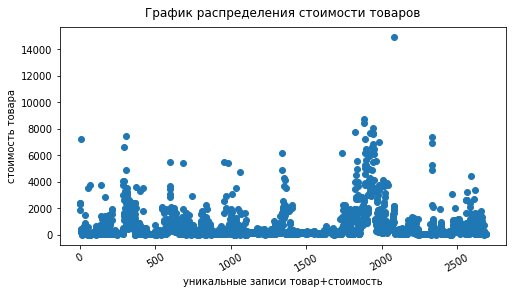

In [11]:
# группировка данных по уникальному названию товара + стоимости товара
product_price_unique = data.groupby(['product','price']).agg({'quantity':'sum'}).reset_index()
# нахождение минимальной и максимальной цены, а также перцентилей
print('Минимальная цена товара:',product_price_unique['price'].min())
print('Средняя цена товара (медиана):',product_price_unique['price'].median())
print('Максимальная цена товара:',product_price_unique['price'].max())
print('95-й и 99-й перцентили стоимости товара:', np.percentile(product_price_unique['price'],[95,99]))
# построение графика визуализации распределения стоимости товаров
plt.figure(figsize=(8, 4))
x_values = pd.Series(range(0,len(product_price_unique)))
plt.scatter(x_values, product_price_unique['price'])
plt.title('График распределения стоимости товаров',y=1.02)
plt.xlabel('уникальные записи товар+стоимость')
plt.ylabel('стоимость товара')
plt.xticks(rotation=30)
plt.show()

<b>Выводы:</b> <br>
- в магазине представлены товары стоимостью от 9 руб. до ~15 тыс. руб.<br>
- средняя стоимость товара составляет около 187 руб. (медиана)<br>
- из всех товаров 5% товаров дороже 2800 руб. и всего 1% товаров дороже 6000 руб.<br>

In [12]:
# анализ товаров дороже 10000 руб.
display(data[data['price'] > 10000])

,date,customer_id,order_id,product,quantity,price,category,day,year_month,total_price
4191,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,сушилка уличная leifheit 85210 linomatic v 400 40 м 175х237х237 см зеленая,1,14917.0,хозтовары,2019-07-29,2019-07,14917.0


<b>Выводы:</b> <br>
Данный товар может стоить около 15 000 рублей => запись не является ошибкой/выбросом => сохранена

####  Анализ категорий товаров

In [13]:
# группировка данных по категориям товара и расчеты показателей
product_category = data.groupby('category').agg(
    {'product':'nunique','quantity':'sum','total_price':'sum'})
product_category.columns = ['unique_products','total_quantity','total_revenue']
product_category['total_revenue'] = round(product_category['total_revenue'],2)
# дополнительные расчеты долей
product_category['total_quantity_share'] = round(product_category['total_quantity'] / product_category['total_quantity'].sum(),3)
product_category['total_revenue_share'] = round(product_category['total_revenue'] / product_category['total_revenue'].sum(),3)
display(product_category.sort_values(by='total_revenue_share',ascending= False))

,unique_products,total_quantity,total_revenue,total_quantity_share,total_revenue_share
category,,,,,
хозтовары,770,5963,3037581.25,0.413,0.657
растения,901,4008,531525.33,0.278,0.115
текстиль,171,488,405526.50,0.034,0.088
посуда,193,1033,205977.00,0.072,0.045
декоративные товары,160,2464,166967.33,0.171,0.036
кухонные принадлежности,112,410,166732.00,0.028,0.036
мебель,26,60,99446.00,0.004,0.022
техника,5,5,6956.00,0.000,0.002


<b>Выводы:</b> <br>
На основании данных по продажам товаров по категориям можно сделать объединение категорий:<br>
=> объединить категории "Посуда" и "Кухонные принадлежности" (их доля по отдельности по выручке менее 5%) в "Товары для кухни"<br>
=> "Декоративные товары" сохранить как отдельную категорию (их доля в выручке небольшая, но доля в кол-ве товаров составляет 17%)<br>
=> категории "Мебель" и "Техника" (доля по выручке 2% и 0,01%) объединить с категорией "Хозтовры" и переименовать в "Товары для дома" <br>

In [14]:
# создание функции для новой категоризации товаров (укрупнение категорий)
house_goods = ['хозтовары','мебель','техника']
kitchen_goods = ['посуда','кухонные принадлежности']
def category_2 (row):
    if row in house_goods:
        return 'товары для дома'
    if row in kitchen_goods:
        return 'товары для кухни'
    return row
# применение работы функций - создание нового столбца
data['category_2'] = data['category'].apply(category_2)
# проверка работы функции
print(data['category_2'].unique())

['растения' 'товары для дома' 'товары для кухни' 'декоративные товары'
 'текстиль']


,unique_products,total_quantity,total_revenue,product_share,total_quantity_share,total_revenue_share
category_2,,,,,,
товары для дома,801,6028,3143983.25,0.343,0.418,0.680
растения,901,4008,531525.33,0.385,0.278,0.115
текстиль,171,488,405526.50,0.073,0.034,0.088
товары для кухни,305,1443,372709.00,0.130,0.100,0.081
декоративные товары,160,2464,166967.33,0.068,0.171,0.036


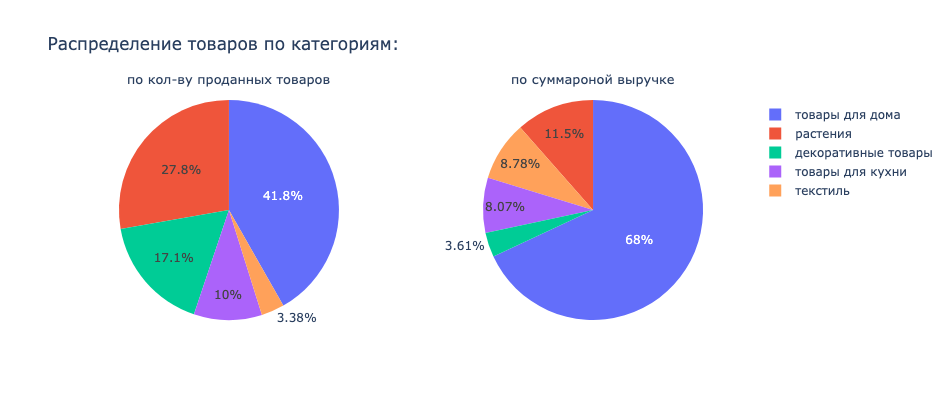

In [15]:
# группировка данных по обновленным категориям и расчеты показателей
product_category_2 = data.groupby('category_2').agg(
    {'product':'nunique','quantity':'sum','total_price':'sum'})
product_category_2.columns = ['unique_products','total_quantity','total_revenue']
product_category_2['total_revenue'] = round(product_category_2['total_revenue'],2)
# дополнительные расчеты долей категорий
product_category_2['product_share'] = round(product_category_2['unique_products'] / product_category_2['unique_products'].sum(),3)
product_category_2['total_quantity_share'] = round(product_category_2['total_quantity'] / product_category_2['total_quantity'].sum(),3)
product_category_2['total_revenue_share'] = round(product_category_2['total_revenue'] / product_category_2['total_revenue'].sum(),3)
display(product_category_2.sort_values(by='total_revenue_share',ascending= False))
# визуализация распределения товаров по категориям
fig = make_subplots(
    rows=1, cols=2,specs=[[{"type": "pie"}, {"type": "pie"}]],
    subplot_titles=('по кол-ву проданных товаров', 'по суммароной выручке'))
fig.add_trace(go.Pie(
   values=product_category_2['total_quantity'],
   labels=product_category_2.index), row=1, col=1)
fig.add_trace(go.Pie(
   values=product_category_2['total_revenue'],
   labels=product_category_2.index), row=1, col=2)
fig.update_layout(
    title_text='Распределение товаров по категориям:',
    width=950, height=400)
fig.update_annotations(font_size=13, y=1.05)
fig.show(renderer='png', width = 950, height = 400)

<b>Выводы:</b> <br>
- по кол-ву проданных за весь период лидируют: "Товары для дома", "Растения" и "Декоративные товары"  <br>
- по суммарной выручке за весь период лидируют: "Товары для дома" (68%), остальные категрии не превышают по выручке 12%  <br>
- категория "Товары для дома" явный лидер (самое большое кол-во товаров и самая большая выручка) <br>

<b>/ Анализ динамики продаж товаров по категориям (сезонность) </b>

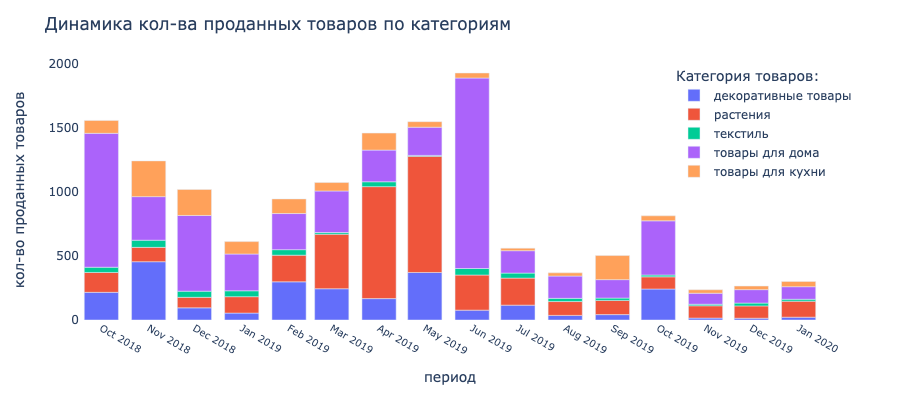

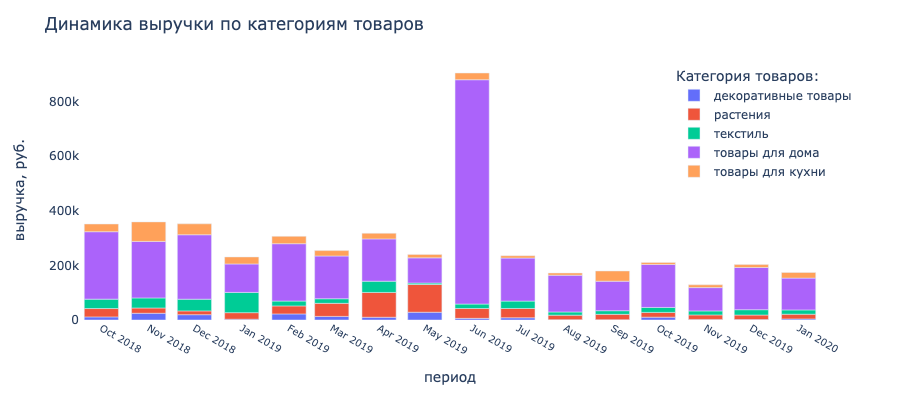

In [16]:
# группировка данных по месяцам по категориям
category_by_month = data.groupby(['year_month','category_2'],as_index = False).agg(
    {'quantity':'sum','total_price':'sum'})
category_by_month.columns = ['date','category','total_quantity','total_revenue']
# визуализация кол-ва проданных товаров по категориям
fig = px.bar(category_by_month, x='date', y='total_quantity',  color='category')
fig.update_xaxes(tickangle=30, dtick="M1", tickfont=dict(size=10))
fig.update_layout(
    width=900, height=400,
    title="Динамика кол-ва проданных товаров по категориям",
    xaxis_title="период",
    yaxis_title="кол-во проданных товаров",
    plot_bgcolor = "rgba(0,0,0,0)",
    legend_title_text='Категория товаров:',
    legend = dict(yanchor="top",  y=0.99, xanchor="right", x=1.05 ) )
fig.show(renderer='png', width = 900, height = 400)
# визуализация динамики выручки по категориям
fig = px.bar(category_by_month, x='date', y='total_revenue',  color='category')
fig.update_xaxes(tickangle=30, dtick="M1", tickfont=dict(size=10))
fig.update_layout(
    width=900, height=400,
    title="Динамика выручки по категориям товаров",
    xaxis_title="период",
    yaxis_title="выручка, руб.",
    font=dict(size=12),
    plot_bgcolor = "rgba(0,0,0,0)",
    legend_title_text='Категория товаров:',
    legend = dict(yanchor="top",  y=0.99, xanchor="right", x=1.05 ) )
fig.show(renderer='png', width = 900, height = 400)

<b>Выводы:</b> <br>
- товары категории "Товары для дома" продаются активно во все месяцы года<br>
- у товаров категории "Растения" имеется сезонность: активные месяцы апрель и май<br>
- товары категорий "Текстиль" и "Товары для кухни" продаются равномерно по году в небольших объемах <br>
- товары категории "Декоративные товары" продаются неравномерно по году (большие или малые объемы в месяц): сезонных месяцев не выявлено<br>

<div style="border:solid lightblue 2px; padding: 5px">
<b>Вывод по разделу №2:</b> <br>
1. Анализ общих показателей: <br>
- выручка за 16 месяцев составила более 4,5 млн. рублей и было продано 14,3 тыс. товаров    <br>
- в 2018 году ежемесячная выручка выше, чем в те же месяцы 2019 года => наблюдается снижение выручки магазина<br>
- кол-во проданных товаров резко снижается после июня 2019 года, при этом кол-во заказов не снижается и растет => в заказе становится меньше товаров с июля 2019 года<br>
- ежемесячное кол-во уникальных покупателей сохраняется на протяжении периода практически на постоянном уровне (нет всплесков)<br>
- повторные покупки совершают лишь 6,5% покупателей (93,5% покупателей сделали 1 заказ)<br>
<br>
2. Анализ товаров: <br>
- в магазине представлены товары стоимостью от 9 руб. до ~15 тыс. руб.<br>
- средняя стоимость товара составляет около 187 руб. (медиана)<br>
- из всех товаров 5% товаров дороже 2800 руб. и всего 1% товаров дороже 6000 руб.<br>
    <br>
Проведено объединение категорий товаров в итоговые 5 категорий: 'Растения', 'Товары для дома', 'Товары для кухни', 'Декоративные товары',
 'Текстиль':<br>
- по кол-ву проданных за весь период лидируют: "Товары для дома", "Растения" и "Декоративные товары"<br>
- по суммарной выручке за весь период лидируют: "Товары для дома" (68%), остальные категрии не превышают по выручке 12%<br>
<br>

###  Сегментация покупателей

In [17]:
# группировка данных по уникальному номеру покупателя
customers_analysis = data.groupby('customer_id',as_index = False).agg(
    {'order_id':'nunique','product':'nunique','quantity':'sum','total_price':'sum','day':'max' })
customers_analysis.columns = ['customer_id','orders_total','unique_products','total_quantity','total_revenue','last_purchase_date']
# дополнительный расчет средней стоимости заказа
customers_analysis['avg_order'] = round(customers_analysis['total_revenue']/customers_analysis['orders_total'],3)
# анализ даты заказа и добавление даты для анализа - 01 февраля 2020 года (день после максимально даты, на которую есть данные в датасете)
customers_analysis['last_purchase_date'] = customers_analysis['last_purchase_date'].map(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
customers_analysis['analysis_date'] = dt(2020, 2, 1).date()
customers_analysis['analysis_date'] = customers_analysis['analysis_date'].map(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
# расчет периода неактивности пользователя (с 01 февраля 2020 года по дату последней покупки)
customers_analysis['unactive_period'] = customers_analysis['analysis_date'] - customers_analysis['last_purchase_date']
customers_analysis['unactive_period'] = customers_analysis['unactive_period'].dt.days
# анализ покупателей по кол-ву заказов и проверка расчетов
display(customers_analysis.sort_values(by='orders_total',ascending= False).head(5))

,customer_id,orders_total,unique_products,total_quantity,total_revenue,last_purchase_date,avg_order,analysis_date,unactive_period
1897,c971fb21-d54c-4134-938f-16b62ee86d3b,126,130,334,159508.0,2019-03-06,1265.937,2020-02-01,332
733,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35,44,309,57278.0,2018-10-24,1636.514,2020-02-01,465
1088,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17,17,17,21361.0,2019-10-31,1256.529,2020-02-01,93
1731,b7b865ab-0735-407f-8d0c-31f74d2806cc,7,18,68,3779.0,2019-04-23,539.857,2020-02-01,284
17,0184f535-b60a-4914-a982-231e3f615206,5,30,58,5891.0,2019-05-23,1178.200,2020-02-01,254


<b>Выводы:</b> <br>
- по кол-ву заказов на покупателя у самого активного покупателя 126 заказов и выручка около 160 тыс.руб. (такое кол-во заказов возможно, не является выбросом)<br>
- далее у активных покупателей 35 и 17 заказов, что также не является выбросами / аномалиями

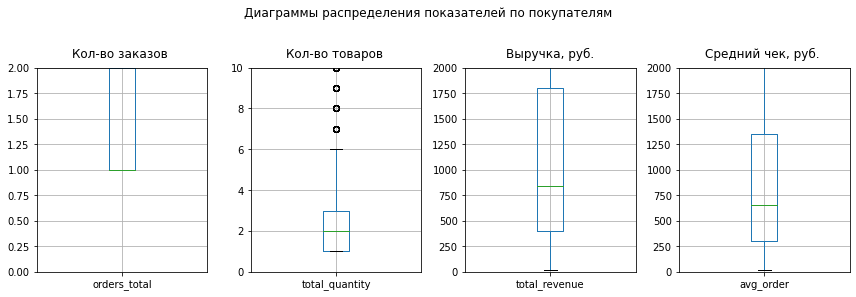

In [18]:
# визуализация распределения данных по покупателям через диаграммы распределения
fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(12,4))
customers_analysis.boxplot(column='orders_total',ax = ax1)
customers_analysis.boxplot(column='total_quantity', ax = ax2)
customers_analysis.boxplot(column='total_revenue', ax = ax3)
customers_analysis.boxplot(column='avg_order', ax = ax4)
ax1.set_ylim([0, 2])
ax2.set_ylim([0, 10])
ax3.set_ylim([0, 2000])
ax4.set_ylim([0, 2000])
fig.suptitle('Диаграммы распределения показателей по покупателям', fontsize=12, y = 1.02)
ax1.set_title('Кол-во заказов ', y = 1.02)
ax2.set_title('Кол-во товаров ', y = 1.02)
ax3.set_title('Выручка, руб.', y = 1.02)
ax4.set_title('Средний чек, руб. ', y = 1.02)
plt.tight_layout()
plt.show()

<b>Выводы:</b> <br>
- среднее кол-во заказов на покупателя = 1 (ранее было установлено, что 93,5% покупателей сделали 1 заказ)<br>
- среднее кол-во товаров на покупателя составляет около 2х <br>
- медиана выручки на покупателя составляет около 800 рублей, разброс квартилей от 400 до 1750 руб.<br>
- медиана выручки на покупателя составляет около 800 рублей, разброс квартилей от 400 до 1750 руб. => что совпадает с выручкой, так как большинство покупателей сделали 1 заказ <br>

In [19]:
# дополнительный расчет перцентилей для дальнейшей сегментации 
print('Персентили показателей: 25% / 50% / 75% / 90% / 95%')
print()
print('Кол-во заказов на покупателя:', np.percentile(customers_analysis['orders_total'],[25,50,75,90,95]))
print('Кол-во купленных товаров на покупателя:', np.percentile(customers_analysis['total_quantity'],[25,50,75,90,95]))
print('Выручка на покупателя, руб.:', np.percentile(customers_analysis['total_revenue'],[25,50,75,90,95]))
print('Средняя стоимость заказа покупателя, руб.:', np.percentile(customers_analysis['avg_order'],[25,50,75,90,95]))
print('Период неактивности, дней:', np.percentile(customers_analysis['unactive_period'],[25,50,75,90,95]))

Персентили показателей: 25% / 50% / 75% / 90% / 95%

Кол-во заказов на покупателя: [1. 1. 2. 2. 2.]
Кол-во купленных товаров на покупателя: [ 1.  2.  3. 10. 20.]
Выручка на покупателя, руб.: [ 396.   839.  1799.  3402.4 4902.4]
Средняя стоимость заказа покупателя, руб.: [ 300.   652.  1349.  2553.6 3748.6]
Период неактивности, дней: [ 74. 211. 345. 431. 459.]


<b>Выводы:</b> <br>
Данные по перцентилям будут использованы в RFM анализе <br>

<div style="border:solid lightblue 2px; padding: 5px">
<b>RFM-анализ профилей покупателей </b><br>
<br>
Сегментация покупателей по RFM анализу с ручной настройкой параметров на основании расчета перцентилей:<br>
<br>
<b>Recency</b> (кол-во дней с даты последнего заказа): <br>
- 1 = более 365 дней / сделали последнюю покупку больше года назад<br>
- 2 = от 212 до 365 дней / были в магазине давно, но сделали покупку за последний год <br>
- 3 = меньше 212 дней (50% покупателей) / были в магазине недавно<br>
<br>
<b>Frequency</b> (кол-во заказов на попупателя): <br>
- 1 = 1 заказ / разовые посетители <br>
- 2 = 2 заказа / заинтересованные посетители <br>
- 3 = больше 2х заказов / постоянные клиенты <br> 
<br>
<b>Monetary</b> (сумма покупок: расчет на основании общей выручки за период):<br>
- 1 = менее 831 рублей (50% покупателей) / низкодоходные покупатели<br>
- 2 = от 831 рублей до 3367 (40% покупателей) / высокодоходные покупатели<br>
- 3 = больше 3367 рублей (10% покупателей) / самые доходные покупатели

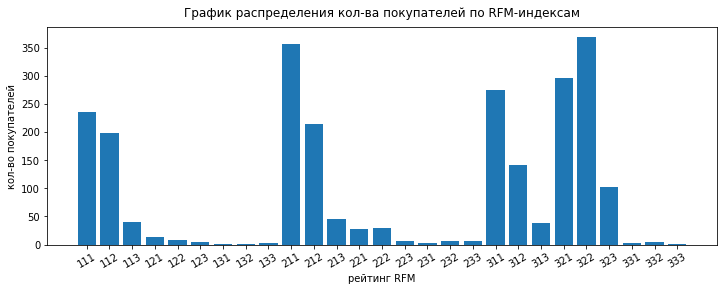

In [20]:
# создание функции для расчета Recency
def R_score(row):
     if row > 365:
         return 1
     elif row > 212:
         return 2
     else:
         return 3
# создание функции для расчета Frequency
def F_score(row):
     if row == 1:
         return 1
     elif row == 2:
         return 2
     else:
         return 3
# создание функции для расчета Monetary
def M_score(row):
     if row <= 831:
         return 1
     elif row <= 3367:
         return 2
     else:
         return 3
# применение функций RFM-анализа
customers_analysis['R_score'] = customers_analysis['unactive_period'].apply(R_score)
customers_analysis['F_score'] = customers_analysis['orders_total'].apply(F_score)
customers_analysis['M_score'] = customers_analysis['total_revenue'].apply(M_score)
customers_analysis['RFM_score'] = customers_analysis['R_score'].map(str)+customers_analysis['F_score'].map(str)+customers_analysis['M_score'].map(str)
# проверка работы функций
#display(customers_analysis.head(1))
# группировка покупателей по RFM-индексам
rfm_analysis = customers_analysis.groupby('RFM_score').agg({'customer_id':'count'})
plt.figure(figsize=(12, 4))
plt.bar(rfm_analysis.index,rfm_analysis['customer_id'])
plt.title('График распределения кол-ва покупателей по RFM-индексам',y=1.02)
plt.xlabel('рейтинг RFM')
plt.ylabel('кол-во покупателей')
plt.xticks(rotation=30)
plt.show()

<b>Выводы:</b> <br>
На основании RFM-анализа получено 27 групп. <br>
Для дальнейшего анализа сегменты будут укрупнены до 5 групп.<br>
<br>
<b>Итоговая сегментация:</b> <br>
- Группа 1: неактивные покупатели (lost_clients) - последняя покупка была больше года назад и не более 2х заказов или совершили более 212 дней назад всего 1 заказ, выручка средняя и ниже (R=1/F=1,2/M=1,2, R=2/F=1/M=1,2 ) <br>
- Группа 2: покупатели с низкой активностью (low_activity) - последняя покупка была больше года назад и высокая выручка/больше 2х заказов или последняя покупка была больше 212 дней назад и больше 1 заказа / высокая выручка (R=1/F=1,2/M=3, R=1/F=3, R=2/F=2,3)<br>
- Группа 3: активные низкодоходные (active_low_income) - покупали недавно, выручка небольшая (R=3/M=1)<br>
- Группа 4: активные высокодоходные (active_high_income) - покупали недавно, выручка средняя (R=3/M=2)<br>
- Группа 5: вип-клиенты (vip_clients) - покупали за последний год и выручка в ТОП 10% клиентов (R=2,3/M=3)<br>

In [21]:
# создание списков с рейтингом RFM для группировки покупателей по итоговым сегментам
lost_clients = ['111', '112', '121', '122', '211', '212' ]
low_activity = ['113', '123', '131', '132', '133',  '221', '222', '231', '232']
active_low_income = ['311', '321', '331']
active_high_income = ['312', '322', '332']
vip_clients = ['213', '223', '233','313', '323', '333' ]

In [22]:
# создание функции сегментации покупателей на основании списков с рейтингом RFM 
def segmentation (row):
    if row in lost_clients:
        return 'lost_clients'
    if row in low_activity:
        return 'low_activity'
    if row in active_low_income:
        return 'active_low_income'
    if row in active_high_income:
        return 'active_high_income'
    if row in vip_clients:
        return 'vip_clients'
    return 'другое'
# применение функции
customers_analysis['segment'] = customers_analysis['RFM_score'].apply(segmentation)
# проверка работы функции
print(customers_analysis['segment'].unique())

['active_low_income' 'lost_clients' 'active_high_income' 'vip_clients'
 'low_activity']


<b>Выводы:</b> <br>
Функция по сегментации отработала корректно: покупатели разделены на 5 сегментов: 'active_low_income','lost_clients', 'active_high_income', 'vip_clients', 'low_activity'  <br>

,customers,customers_share
segment,,
lost_clients,1027,0.423
active_low_income,573,0.236
active_high_income,514,0.212
vip_clients,199,0.082
low_activity,116,0.048


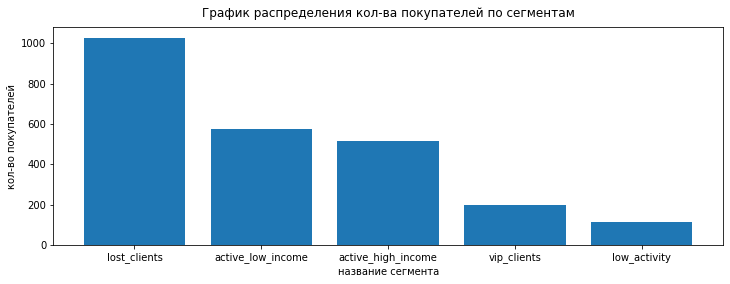

In [23]:
# группировка данных по сегментам
segments = customers_analysis.groupby('segment').agg({'customer_id':'count'}).sort_values(by='customer_id',ascending = False)
segments.columns = ['customers']
# дополнительный расчет доли сегмента
segments['customers_share'] = round(segments['customers']/segments['customers'].sum(),3)
display(segments)
# визуализация кол-ва покупателей по сегментам
plt.figure(figsize=(12, 4))
plt.bar(segments.index,segments['customers'])
plt.title('График распределения кол-ва покупателей по сегментам',y=1.02)
plt.xlabel('название сегмента')
plt.ylabel('кол-во покупателей')
plt.show()

<b>Выводы:</b> <br>
- большинство покупателей (43%) в сегменте "неактивные" (lost_clients)<br>
- большая доля покупателей в сегментах активных низкодоходных (active_low_income) = 24% и активных высокодоходных (active_high_income) = 21%<br>
- vip-клиентов (vip_clients) = 8%<br>
- покупателей с низкой активностью (low_activity) = 5%<br>
<br>
<b>Дополнительно:</b> <br>
- можно дополнительно разделить сегмент с низкой активностью (low_activity) на 2 под-сегмента в зависимости от дохода с покупателя (низкодоходные и высокодоходные), но кол-во покупателей в данном сегменте крайне мало <br>
=> сегмент low_activity сохранен как единый сегмент вне зависимости от доходности покупателя

<div style="border:solid lightblue 2px; padding: 5px">
<b>Вывод по разделу №3:</b> <br>
1. Анализ профилей покупателей:<br>
- среденне кол-во заказов на покупателя = 1 <br>
- среднее кол-во товаров на покупателя составляет около 2х<br>
- медиана выручки на покупателя составляет около 800 рублей, разброс квартилей от 400 до 1750 руб.<br>
<br>                                                                                                      
2. Проведен RFM анализ и дополнительная сегментация по 5 группам покупателей: неактивные покупатели / покупатели с низкой активностью / активные низкодоходные / активные высокодоходные /  вип-клиенты <br>
- большинство покупателей (43%) в сегменте "неактивные" <br>
- большая доля покупателей в сегментах активных низкодоходных (active_low_income) и активных высокодоходных (active_high_income) ~ по 20%<br>
- vip-клиентов (vip_clients) 8%<br>

### Проверка гипотез о различиях сегментов

В данном разделе будут проверены гипотезы о разнице в профилях покупателей из различных сегментов.<br>
<br>
<b> Метод проверки гипотез:</b><br>
Тест: t-test о равенстве среднего двух генеральных совокупностей (st.ttest_ind) с поправкой на множественность <br>
Уроень статистической значимости alpha: 5%  <br>
<br>
<b> Описание групп для проверки гипотез: </b> <br>
group_A = "вип-клиенты" (vip_clients)<br>
group_B = "активные высокодоходные" (active_high_income) <br>
group_C = "активные низкодоходные" (active_low_income)<br>
group_D = "покупатели с низкой активностью" (low_activity) <br>
<br>
<b> Дополнительно:</b><br>
Сегмент "неактивные клиенты" (lost_clients) не будет задейсвован в проверке гипотез и по нему не будут выявлены предпочтения и рекомендации по продвижению.<br>

<b> / Гипотеза №1 </b> <br>
Гипотеза о разнице средней стоимости заказа по сегментам: <br>
H0 = средняя стоимость заказов у сегментов покупателей одинаковая <br>
H1 = средняя стоимость заказов у сегментов покупателей отличается <br>
*за весь период данных по покупкам <br>

In [24]:
# группировка данных по средней стоимости заказа
group_A_avg_order = customers_analysis[customers_analysis['segment'] == 'vip_clients' ]['avg_order']
group_B_avg_order = customers_analysis[customers_analysis['segment'] == 'active_high_income' ]['avg_order']
group_C_avg_order = customers_analysis[customers_analysis['segment'] == 'active_low_income' ]['avg_order']
group_D_avg_order = customers_analysis[customers_analysis['segment'] == 'low_activity' ]['avg_order']

In [25]:
# уровень статистической значимости
alpha = 0.05 
alpha_mn = alpha / 6
# проведение теста
results_AB = st.ttest_ind(group_A_avg_order, group_B_avg_order)
results_AC = st.ttest_ind(group_A_avg_order, group_C_avg_order)
results_AD = st.ttest_ind(group_A_avg_order, group_D_avg_order)
results_BC = st.ttest_ind(group_B_avg_order, group_C_avg_order)
results_BD = st.ttest_ind(group_B_avg_order, group_D_avg_order)
results_CD = st.ttest_ind(group_C_avg_order, group_D_avg_order)
# результаты
print('p-значение для сравнения групп А и B: ', round(results_AB.pvalue,7))
print('p-значение для сравнения групп A и C: ', round(results_AC.pvalue,7))
print('p-значение для сравнения групп A и D: ', round(results_AD.pvalue,7))
print('p-значение для сравнения групп B и C: ', round(results_BC.pvalue,7))
print('p-значение для сравнения групп B и D: ', round(results_BD.pvalue,7))
print('p-значение для сравнения групп C и D: ', round(results_CD.pvalue,7))
if results_AB.pvalue < alpha_mn:
    print('Отвергаем нулевую гипотезу для сравнения групп A и B')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп A и B')
if results_AC.pvalue < alpha_mn:
    print('Отвергаем нулевую гипотезу для сравнения групп A и C')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп A и C')
if results_AD.pvalue < alpha_mn:
    print('Отвергаем нулевую гипотезу для сравнения групп A и D')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп A и D')    
if results_BC.pvalue < alpha_mn:
    print('Отвергаем нулевую гипотезу для сравнения групп B и C')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C')  
if results_BD.pvalue < alpha_mn:
    print('Отвергаем нулевую гипотезу для сравнения групп B и D')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп B и D')      
if results_CD.pvalue < alpha_mn:
    print('Отвергаем нулевую гипотезу для сравнения групп C и D')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп C и D')  

p-значение для сравнения групп А и B:  0.0024325
p-значение для сравнения групп A и C:  0.0003341
p-значение для сравнения групп A и D:  0.3712241
p-значение для сравнения групп B и C:  0.0
p-значение для сравнения групп B и D:  0.0
p-значение для сравнения групп C и D:  0.0
Отвергаем нулевую гипотезу для сравнения групп A и B
Отвергаем нулевую гипотезу для сравнения групп A и C
Не получилось отвергнуть нулевую гипотезу для сравнения групп A и D
Отвергаем нулевую гипотезу для сравнения групп B и C
Отвергаем нулевую гипотезу для сравнения групп B и D
Отвергаем нулевую гипотезу для сравнения групп C и D


<b>Выводы:</b> <br>
- выявлено статистически значимое различие в средней стоимости заказа у групп А, В и C (сегменты "вип-клиенты", "активные высокодоходные", "активные низкодоходные")<br>
- не выявлено статистической значимости различия средней стоимости заказа у групп A и D (сегменты "вип-клиенты" и "покупатели с низкой активностью"), что говорит о том, что среди покупателей с низкой активностью (давно не совершали покупки) очень много покупателей с высоким средним чеком => важно вернуть данных покупателей к повторным покупкам

<b> / Гипотеза №2 </b> <br>
 <br>
Гипотеза о кол-ве покупаемых товаров по сегментам:  <br>
H0 = кол-во купленных товаров у сегменов покупателей одинаковое <br>
H1 = кол-во купленных товаров у сегменов покупателей разное <br>
*за весь период данных по покупкам <br>

In [26]:
# группировка данных по кол-ву купленных товаров
group_A_products_total = customers_analysis[customers_analysis['segment'] == 'vip_clients' ]['total_quantity']
group_B_products_total = customers_analysis[customers_analysis['segment'] == 'active_high_income' ]['total_quantity']
group_C_products_total = customers_analysis[customers_analysis['segment'] == 'active_low_income' ]['total_quantity']
group_D_products_total = customers_analysis[customers_analysis['segment'] == 'low_activity' ]['total_quantity']

In [27]:
# уровень статистической значимости
alpha = 0.05 
alpha_mn = alpha / 6
# проведение теста
results_AB = st.ttest_ind(group_A_products_total, group_B_products_total)
results_AC = st.ttest_ind(group_A_products_total, group_C_products_total)
results_AD = st.ttest_ind(group_A_products_total, group_D_products_total)
results_BC = st.ttest_ind(group_B_products_total, group_C_products_total)
results_BD = st.ttest_ind(group_B_products_total, group_D_products_total)
results_CD = st.ttest_ind(group_C_products_total, group_D_products_total)
# результаты
print('p-значение для сравнения групп А и B: ', round(results_AB.pvalue,7))
print('p-значение для сравнения групп A и C: ', round(results_AC.pvalue,7))
print('p-значение для сравнения групп A и D: ', round(results_AD.pvalue,7))
print('p-значение для сравнения групп B и C: ', round(results_BC.pvalue,7))
print('p-значение для сравнения групп B и D: ', round(results_BD.pvalue,7))
print('p-значение для сравнения групп C и D: ', round(results_CD.pvalue,7))
if results_AB.pvalue < alpha_mn:
    print('Отвергаем нулевую гипотезу для сравнения групп A и B')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп A и B')
if results_AC.pvalue < alpha_mn:
    print('Отвергаем нулевую гипотезу для сравнения групп A и C')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп A и C')
if results_AD.pvalue < alpha_mn:
    print('Отвергаем нулевую гипотезу для сравнения групп A и D')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп A и D')    
if results_BC.pvalue < alpha_mn:
    print('Отвергаем нулевую гипотезу для сравнения групп B и C')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C')  
if results_BD.pvalue < alpha_mn:
    print('Отвергаем нулевую гипотезу для сравнения групп B и D')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп B и D')      
if results_CD.pvalue < alpha_mn:
    print('Отвергаем нулевую гипотезу для сравнения групп C и D')
else:
    print('Не получилось отвергнуть нулевую гипотезу для сравнения групп C и D')  

p-значение для сравнения групп А и B:  8.06e-05
p-значение для сравнения групп A и C:  8.1e-06
p-значение для сравнения групп A и D:  0.5107717
p-значение для сравнения групп B и C:  0.0040454
p-значение для сравнения групп B и D:  0.0
p-значение для сравнения групп C и D:  0.0
Отвергаем нулевую гипотезу для сравнения групп A и B
Отвергаем нулевую гипотезу для сравнения групп A и C
Не получилось отвергнуть нулевую гипотезу для сравнения групп A и D
Отвергаем нулевую гипотезу для сравнения групп B и C
Отвергаем нулевую гипотезу для сравнения групп B и D
Отвергаем нулевую гипотезу для сравнения групп C и D


<b>Выводы:</b> <br>
- выявлена статистическая значимость различия кол-ва покупаемого товара у групп А, В и C (сегменты "вип-клиенты", "активные высокодоходные", "активные низкодоходные") 
- не выявлено статистической значимости различия кол-ва покупаемого товара  у групп A и D (сегменты "вип-клиенты" и "покупатели с низкой активностью"), что говорит о том, что среди покупателей с низкой активностью (давно не совершали покупки) очень много покупателей, купивших большое кол-во товаров => важно вернуть данных покупателей к повторным покупкам

<div style="border:solid lightblue 2px; padding: 5px">
<b>Вывод по разделу №4 проекта:</b> <br>
Общий вывод по результататм проверки гипотез: <br>
<br>    
1. Выявлено статистически значимое различие в средней стоимости заказа и кол-ве покупаемого товара у 3-х групп:<br>
group_A = "вип-клиенты" (vip_clients)<br>
group_B = "активные высокодоходные" (active_high_income) <br>
group_C = "активные низкодоходные" (active_low_income)<br>
=> сегментация этих групп проведена корректна - 3 группы имеют различный профиль потребления<br>
<br>
2. Не выявлено статистически значимого различия в средней стоимости заказа и кол-ве покупаемого товара у 2-х групп:<br>
group_A = "вип-клиенты" (vip_clients)<br>   
group_D = "покупатели с низкой активностью" (low_activity) <br>    
=> среди покупателей с низкой активностью (давно не совершали покупки) очень много покупателей с высокой стоимостью заказа и с большим кол-вом купленного товара  => важно вернуть данных покупателей к повторным покупкам    <br>

### Выявление предпочтений сегментов

In [28]:
# создание отдельного списка с customer_id и сегментом
final_segmentation = customers_analysis[['customer_id','segment']]
# объединение датасета с данными по покупкам и данными по сегменту (в новую переменную)
data_segments = data.merge(final_segmentation,on='customer_id')
# проверка объединения данных
display(data_segments.head(1))

,date,customer_id,order_id,product,quantity,price,category,day,year_month,total_price,category_2,segment
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,растения,2018-10-01,2018-10,142.0,растения,lost_clients


In [29]:
# групировка данных по сегментам
segments_analysis = data_segments.groupby('segment').agg(
    {'customer_id':'nunique','order_id':'nunique','quantity':'sum','total_price':'sum' })
segments_analysis.columns = ['customers','orders','total_quantity','total_revenue']
segments_analysis['total_revenue'] = round(segments_analysis['total_revenue'],2)
segments_analysis['avg_order'] = round(segments_analysis['total_revenue']/segments_analysis['orders'],3)
segments_analysis['customers_share'] = round(segments_analysis['customers']/segments_analysis['customers'].sum(),3)
segments_analysis['total_revenue_share'] = round(segments_analysis['total_revenue']/segments_analysis['total_revenue'].sum(),3)
display(segments_analysis.sort_values(by='avg_order',ascending= False))

,customers,orders,total_quantity,total_revenue,avg_order,customers_share,total_revenue_share
segment,,,,,,,
vip_clients,199,467,3497,2020259.17,4326.037,0.082,0.437
low_activity,116,240,2675,554714.00,2311.308,0.048,0.120
active_high_income,514,890,1653,875508.08,983.717,0.212,0.189
lost_clients,1027,1049,5292,938603.00,894.760,0.423,0.203
active_low_income,573,873,1314,231627.17,265.323,0.236,0.050


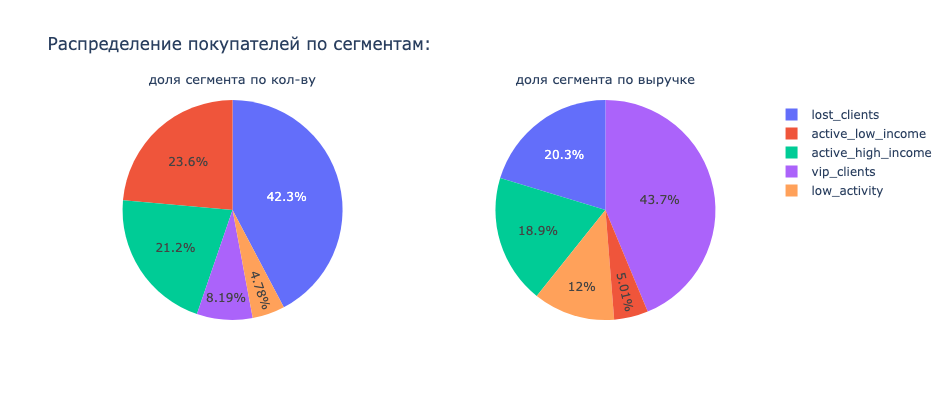

In [30]:
# визуализация распределения клиентов по сегментам
fig = make_subplots(
    rows=1, cols=2,specs=[[{"type": "pie"}, {"type": "pie"}]],
    subplot_titles=('доля сегмента по кол-ву', 'доля сегмента по выручке'))
fig.add_trace(go.Pie(
   values=segments_analysis['customers'],
   labels=segments_analysis.index), row=1, col=1)
fig.add_trace(go.Pie(
   values=segments_analysis['total_revenue'],
   labels=segments_analysis.index), row=1, col=2)
fig.update_layout(
    title_text='Распределение покупателей по сегментам:',
    width=950, height=400)
fig.update_annotations(font_size=13, y=1.05)
fig.show(renderer='png', width = 950, height = 400)

<b>Выводы:</b> <br>
- самые доходные клиенты:  vip_clients, средняя стоимость заказа 5430 руб.
- высокий средний чек (2 349 руб.) у сегмента low_activity (что также было выявлено при проверке гипотез о различии в средней стоимости заказа и кол-ве покупок) => необходимо направить на них маркетинговые активности
- у сегмента active_high_income средняя стоимость заказа 1 621 руб.
- у сегмента active_low_income очень низкая средняя стоимость заказа (392 руб.) => маркетинговая активность для данного сегмента не должна быть высокой
- сегмент lost_clients имеет средний чек в 894 руб., однако вероятность их возвращения в магазин крайне мала.


<b> / Предпочтения сегмента "вип-клиенты" (vip_clients)</b>

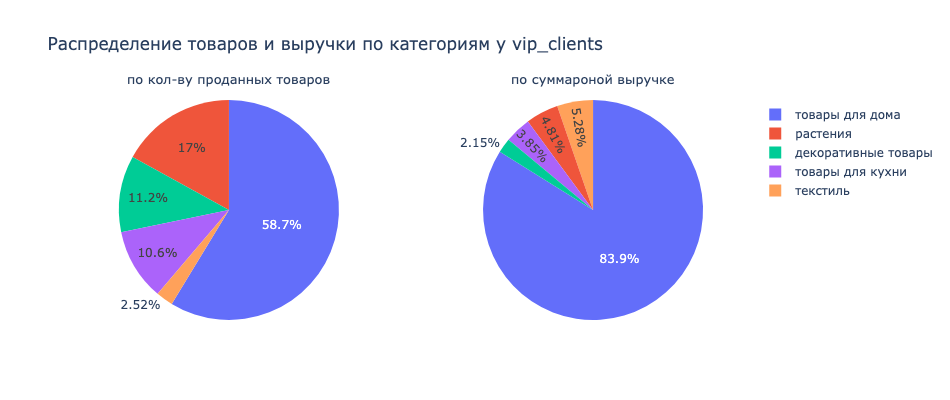

In [31]:
# создание переменной с данными по vip_clients
vip_clients_data = data_segments[data_segments['segment'] == 'vip_clients']
# изучение категорий товаров у vip_clients
vip_clients_category = vip_clients_data.groupby('category_2').agg({'quantity':'sum','total_price':'sum' })
vip_clients_category.columns = ['total_quantity','total_revenue']
vip_clients_category['total_revenue'] = round(vip_clients_category['total_revenue'],2)
vip_clients_category['avg_product_price'] = round(vip_clients_category['total_revenue']/vip_clients_category['total_quantity'],2)
vip_clients_category['quantity_share'] = round(vip_clients_category['total_quantity'] / vip_clients_category['total_quantity'].sum(),2)
vip_clients_category['revenue_share'] = round(vip_clients_category['total_revenue'] / vip_clients_category['total_revenue'].sum(),2)
#display(vip_clients_category.sort_values(by='avg_product_price',ascending= False))
# визуализация распределения товаров по категориям
fig = make_subplots(
    rows=1, cols=2,specs=[[{"type": "pie"}, {"type": "pie"}]],
    subplot_titles=('по кол-ву проданных товаров', 'по суммароной выручке'))
fig.add_trace(go.Pie(
   values = vip_clients_category['total_quantity'],
   labels = vip_clients_category.index), row=1, col=1)
fig.add_trace(go.Pie(
   values = vip_clients_category['total_revenue'],
   labels = vip_clients_category.index), row=1, col=2)
fig.update_layout(
    title_text='Распределение товаров и выручки по категориям у vip_clients',
    width=950, height=400)
fig.update_annotations(font_size=13, y=1.05)
fig.show(renderer='png', width = 950, height = 400)

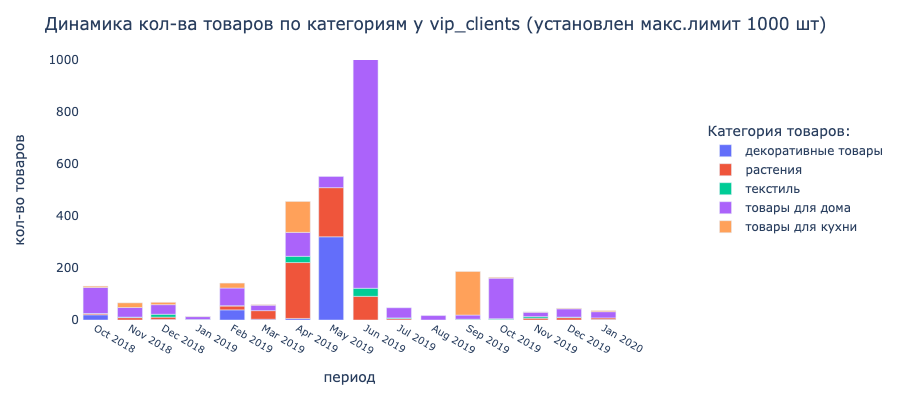

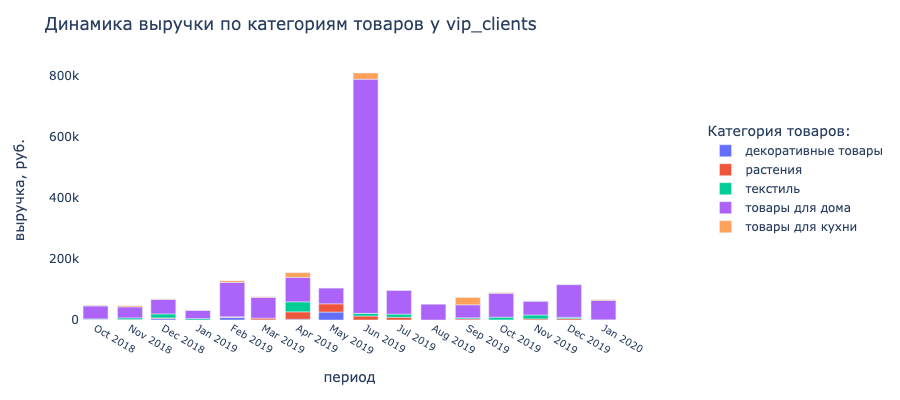

In [32]:
# изучение сезонности покупки товаров у vip_clients
vip_clients_by_month = vip_clients_data.groupby(['year_month','category_2'],as_index = False).agg(
    {'order_id':'nunique','quantity':'sum','total_price':'sum' })
vip_clients_by_month.columns = ['date','category', 'orders', 'total_quantity','total_revenue']
# визуализация динамики кол-ва товаров по категориям
fig = px.bar(vip_clients_by_month, x='date', y='total_quantity',  color='category')
fig.update_xaxes(tickangle=30, dtick="M1", tickfont=dict(size=10))
fig.update_yaxes(range=[0, 1000]) 
fig.update_layout(
    width=900, height=400,
    title="Динамика кол-ва товаров по категориям у vip_clients (установлен макс.лимит 1000 шт)",
    xaxis_title="период",
    yaxis_title="кол-во товаров",
    font=dict(size=12),
    plot_bgcolor = "rgba(0,0,0,0)",
    legend_title_text='Категория товаров:',
    legend = dict(yanchor="bottom",  y= 0.3 , xanchor="right", x= 1.5 ) )
fig.show(renderer='png', width = 900, height = 400)
# визуализация динамими выручки по категориям
fig = px.bar(vip_clients_by_month, x='date', y='total_revenue',  color='category')
fig.update_xaxes(tickangle=30, dtick="M1", tickfont=dict(size=10))
fig.update_layout(
    width=900, height=400,
    title="Динамика выручки по категориям товаров у vip_clients",
    xaxis_title="период",
    yaxis_title="выручка, руб.",
    font=dict(size=12),
    plot_bgcolor = "rgba(0,0,0,0)",
    legend_title_text='Категория товаров:',
    legend = dict(yanchor="bottom",  y= 0.3 , xanchor="right", x= 1.5 ) )
fig.show(renderer='png', width = 900, height = 400)

<b>Выводы по предпочтениям сегмента "вип-клиенты" (vip_clients):</b> <br>
<br>
ТОП-3 популярных категорий товаров (доля купленных товаров, %):<br>
-Товары для дома: 58%<br>
-Растения: 17%<br>
-Декоративные товары: 11%<br>
<br>
Сезонность: <br>
-Товары для дома: активнов покупают во все месяцы<br>
-Растения: покупают с апреля по июнь  <br>
-Декоративные товары, Товары для кухни и Текстиль: нет четко выраженной сезонности (разовые покупки)<br>
<br>
Средняя стоимость купленного товара по категориям: <br>
-Текстиль:  1213 руб.<br>
-Товары для дома: 812 руб.<br>
-Товары для кухни: 209 руб.<br>
-Растения: 163 руб.<br>
-Декоративные товары: 110 руб.<br>

<b> / Предпочтения сегмента "активные высокодоходные" (active_high_income)</b>

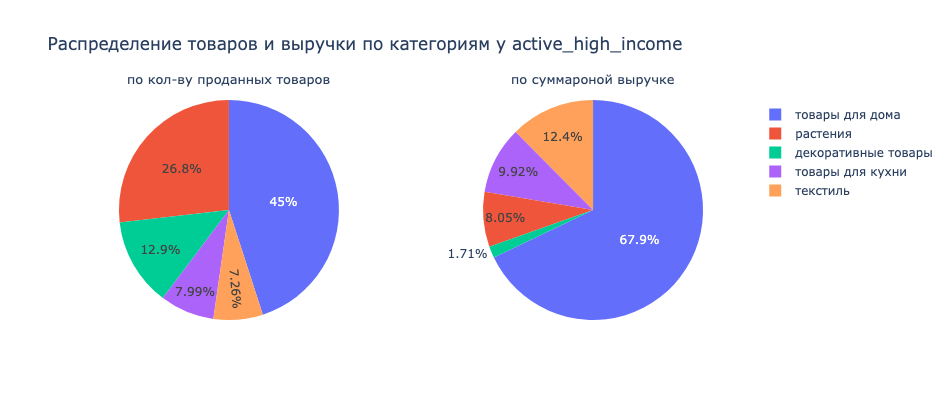

In [33]:
# создание переменной с данными по active_high_income
active_high_income_data = data_segments[data_segments['segment'] == 'active_high_income']
# изучение категорий товаров у active_high_income
active_high_income_category = active_high_income_data.groupby('category_2').agg({'quantity':'sum','total_price':'sum'})
active_high_income_category.columns = ['total_quantity','total_revenue']
active_high_income_category['total_revenue'] = round(active_high_income_category['total_revenue'],2)
active_high_income_category['avg_product_price'] = round(active_high_income_category['total_revenue']/active_high_income_category['total_quantity'],2)
active_high_income_category['quantity_share'] = round(active_high_income_category['total_quantity'] / active_high_income_category['total_quantity'].sum(),2)
active_high_income_category['revenue_share'] = round(active_high_income_category['total_revenue'] / active_high_income_category['total_revenue'].sum(),2)
#display(active_high_income_category.sort_values(by='avg_product_price',ascending= False))
# визуализация распределения товаров по категориям
fig = make_subplots(
    rows=1, cols=2,specs=[[{"type": "pie"}, {"type": "pie"}]],
    subplot_titles=('по кол-ву проданных товаров', 'по суммароной выручке'))
fig.add_trace(go.Pie(
   values = active_high_income_category['total_quantity'],
   labels = active_high_income_category.index), row=1, col=1)
fig.add_trace(go.Pie(
   values = active_high_income_category['total_revenue'],
   labels = active_high_income_category.index), row=1, col=2)
fig.update_layout(
    title_text='Распределение товаров и выручки по категориям у active_high_income',
    width=950, height=400)
fig.update_annotations(font_size=13, y=1.05)
fig.show(renderer='png', width = 950, height = 400)

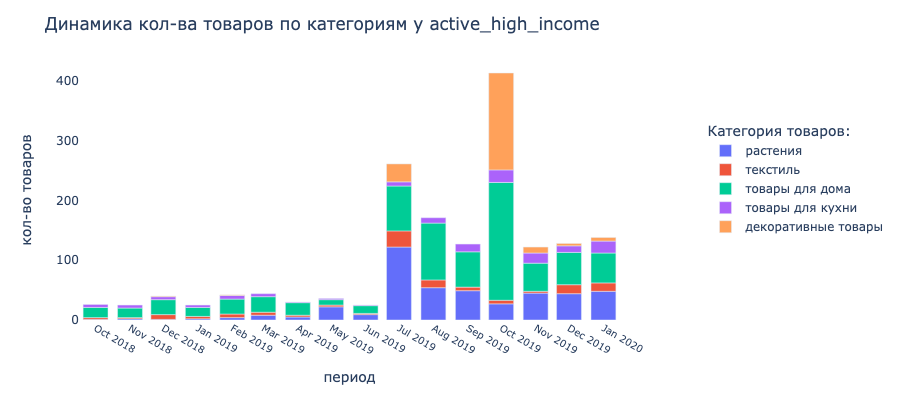

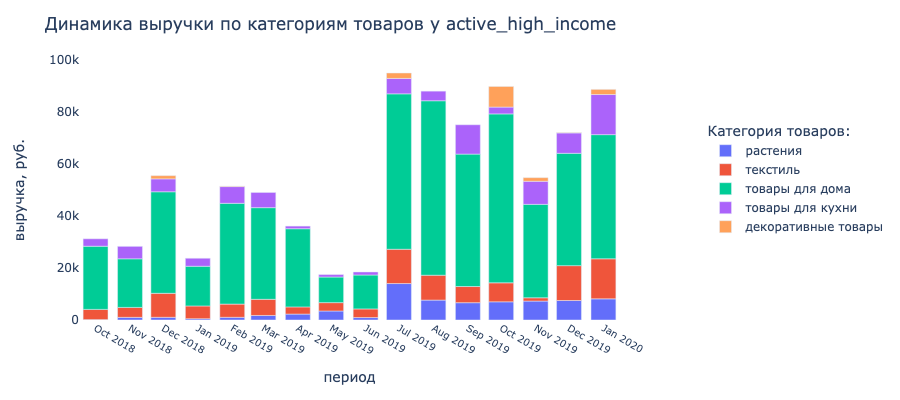

In [34]:
# изучение сезонности покупки товаров у active_high_income
active_high_income_by_month = active_high_income_data.groupby(['year_month','category_2'],as_index = False).agg(
    {'order_id':'nunique','quantity':'sum','total_price':'sum' })
active_high_income_by_month.columns = ['date','category', 'orders', 'quantity','revenue']
# визуализация динамики кол-ва товаров по категориям
fig = px.bar(active_high_income_by_month, x='date', y='quantity',  color='category')
fig.update_xaxes(tickangle=30, dtick="M1", tickfont=dict(size=10))
fig.update_layout(
    width=900, height=400,
    title="Динамика кол-ва товаров по категориям у active_high_income",
    xaxis_title="период",
    yaxis_title="кол-во товаров",
    font=dict(size=12),
    plot_bgcolor = "rgba(0,0,0,0)",
    legend_title_text='Категория товаров:',
    legend = dict(yanchor="bottom",  y= 0.3 , xanchor="right", x= 1.5 ) )
fig.show(renderer='png', width = 900, height = 400)
# визуализация динамими выручки по категориям
fig = px.bar(active_high_income_by_month, x='date', y='revenue',  color='category')
fig.update_xaxes(tickangle=30, dtick="M1", tickfont=dict(size=10))
fig.update_layout(
    width=900, height=400,
    title="Динамика выручки по категориям товаров у active_high_income",
    xaxis_title="период",
    yaxis_title="выручка, руб.",
    font=dict(size=12),
    plot_bgcolor = "rgba(0,0,0,0)",
    legend_title_text='Категория товаров:',
    legend = dict(yanchor="bottom",  y= 0.3 , xanchor="right", x= 1.5 ) )
fig.show(renderer='png', width = 900, height = 400)

<b>Выводы по предпочтениям сегмента "активные высокодоходные" (active_high_income):</b> <br>
<br>
ТОП-3 популярных категорий товаров (доля купленных товаров, %):<br>
-Товары для дома: 45%<br>
-Растения: 27%<br>
-Декоративные товары: 13%<br>
<br>
Сезонность: <br>
-Товары для дома, Растения, Текстиль, Товары для кухни: активно покупают во все месяцы<br>
-Декоративные товары: нет четко выраженной сезонности (разовые покупки)<br>
<br>
Средняя стоимость купленного товара по категориям: <br>
-Текстиль:  900 руб.<br>
-Товары для дома: 811 руб.<br>
-Товары для кухни: 652  руб.<br>
-Растения:  159 руб.<br>
-Декоративные товары: 66 руб.<br>

<b> / Предпочтения сегмента active_low_income</b>

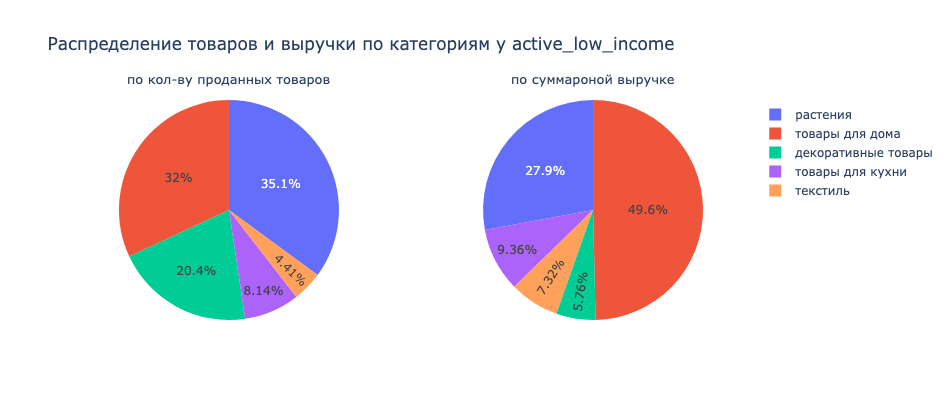

In [35]:
# создание переменной с данными по active_low_income
active_low_income_data = data_segments[data_segments['segment'] == 'active_low_income']
# изучение категорий товаров у active_low_income
active_low_income_category = active_low_income_data.groupby('category_2').agg({'quantity':'sum','total_price':'sum' })
active_low_income_category.columns = ['total_quantity','total_revenue']
active_low_income_category['total_revenue'] = round(active_low_income_category['total_revenue'],2)
active_low_income_category['avg_product_price'] = round(active_low_income_category['total_revenue']/active_low_income_category['total_quantity'],2)
active_low_income_category['quantity_share'] = round(active_low_income_category['total_quantity'] / active_low_income_category['total_quantity'].sum(),2)
active_low_income_category['revenue_share'] = round(active_low_income_category['total_revenue'] / active_low_income_category['total_revenue'].sum(),2)
#display(active_low_income_category.sort_values(by='avg_product_price',ascending= False))
# визуализация распределения товаров по категориям
fig = make_subplots(
    rows=1, cols=2,specs=[[{"type": "pie"}, {"type": "pie"}]],
    subplot_titles=('по кол-ву проданных товаров', 'по суммароной выручке'))
fig.add_trace(go.Pie(
   values = active_low_income_category['total_quantity'],
   labels = active_low_income_category.index), row=1, col=1)
fig.add_trace(go.Pie(
   values = active_low_income_category['total_revenue'],
   labels = active_low_income_category.index), row=1, col=2)
fig.update_layout(
    title_text='Распределение товаров и выручки по категориям у active_low_income',
    width=950, height=400)
fig.update_annotations(font_size=13, y=1.05)
fig.show(renderer='png', width = 950, height = 400)

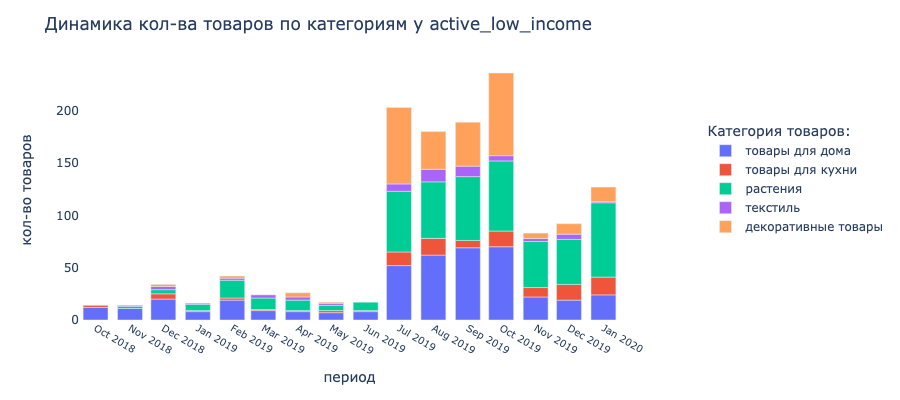

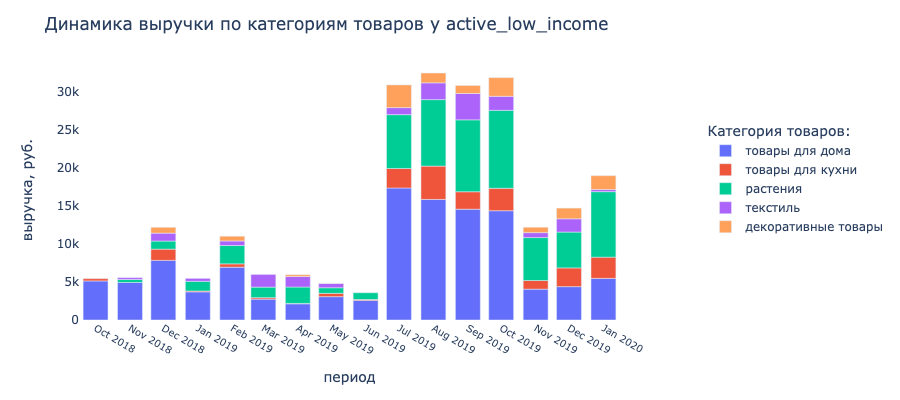

In [36]:
# изучение сезонности покупки товаров у active_low_income
active_low_income_by_month = active_low_income_data.groupby(['year_month','category_2'],as_index = False).agg(
    {'order_id':'nunique','quantity':'sum','total_price':'sum' })
active_low_income_by_month.columns = ['date','category', 'orders', 'quantity','revenue']
# визуализация динамики кол-ва товаров по категориям
fig = px.bar(active_low_income_by_month, x='date', y='quantity',  color='category')
fig.update_xaxes(tickangle=30, dtick="M1", tickfont=dict(size=10))
fig.update_layout(
    width=900, height=400,
    title="Динамика кол-ва товаров по категориям у active_low_income",
    xaxis_title="период",
    yaxis_title="кол-во товаров",
    font=dict(size=12),
    plot_bgcolor = "rgba(0,0,0,0)",
    legend_title_text='Категория товаров:',
    legend = dict(yanchor="bottom",  y= 0.3 , xanchor="right", x= 1.5 ) )
fig.show(renderer='png', width = 900, height = 400)
# визуализация динамими выручки по категориям
fig = px.bar(active_low_income_by_month, x='date', y='revenue',  color='category')
fig.update_xaxes(tickangle=30, dtick="M1", tickfont=dict(size=10))
fig.update_layout(
    width=900, height=400,
    title="Динамика выручки по категориям товаров у active_low_income",
    xaxis_title="период",
    yaxis_title="выручка, руб.",
    font=dict(size=12),
    plot_bgcolor = "rgba(0,0,0,0)",
    legend_title_text='Категория товаров:',
    legend = dict(yanchor="bottom",  y= 0.3 , xanchor="right", x= 1.5 ) )
fig.show(renderer='png', width = 900, height = 400)

<b>Выводы по предпочтениям сегмента "активные низкодоходные" (active_low_income):</b> <br>
<br>
ТОП-3 популярных категорий товаров (доля купленных товаров, %):<br>
-Растения: 35%<br>
-Товары для дома: 31%<br>
-Декоративные товары: 21%<br>
<br>
Сезонность: <br>
-Товары для дома, Растения, Товары для кухни и Декоративные товары: активно покупают во все месяцы<br>
-Текстиль: нет четко выраженной сезонности (разовые покупки)<br>
<br>
Средняя стоимость купленного товара по категориям: <br>
-Текстиль:  296 руб.<br>
-Товары для дома: 278 руб.<br>
-Товары для кухни: 208 руб.<br>
-Растения:  141 руб.<br>
-Декоративные товары: 51 руб.<br>

<b> / Предпочтения сегмента low_activity</b>

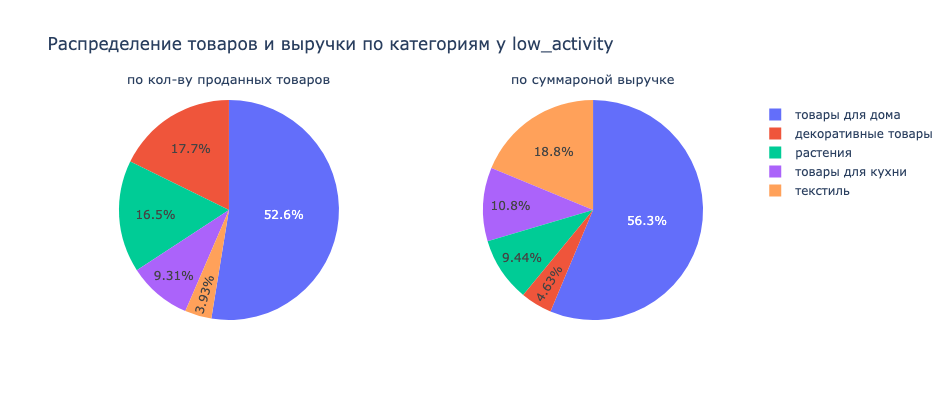

In [37]:
# создание переменной с данными по low_activity
low_activity_data = data_segments[data_segments['segment'] == 'low_activity']
# изучение категорий товаров у low_activity
low_activity_category = low_activity_data.groupby('category_2').agg({'quantity':'sum','total_price':'sum' })
low_activity_category.columns = ['total_quantity','total_revenue']
low_activity_category['total_revenue'] = round(low_activity_category['total_revenue'],2)
low_activity_category['avg_product_price'] = round(low_activity_category['total_revenue']/low_activity_category['total_quantity'],2)
low_activity_category['quantity_share'] = round(low_activity_category['total_quantity'] / low_activity_category['total_quantity'].sum(),2)
low_activity_category['revenue_share'] = round(low_activity_category['total_revenue'] / low_activity_category['total_revenue'].sum(),2)
#display(low_activity_category.sort_values(by='avg_product_price',ascending= False))
# визуализация распределения товаров по категориям
fig = make_subplots(
    rows=1, cols=2,specs=[[{"type": "pie"}, {"type": "pie"}]],
    subplot_titles=('по кол-ву проданных товаров', 'по суммароной выручке'))
fig.add_trace(go.Pie(
   values = low_activity_category['total_quantity'],
   labels = low_activity_category.index), row=1, col=1)
fig.add_trace(go.Pie(
   values = low_activity_category['total_revenue'],
   labels = low_activity_category.index), row=1, col=2)
fig.update_layout(
    title_text='Распределение товаров и выручки по категориям у low_activity',
    width=950, height=400)
fig.update_annotations(font_size=13, y=1.05)
fig.show(renderer='png', width = 950, height = 400)

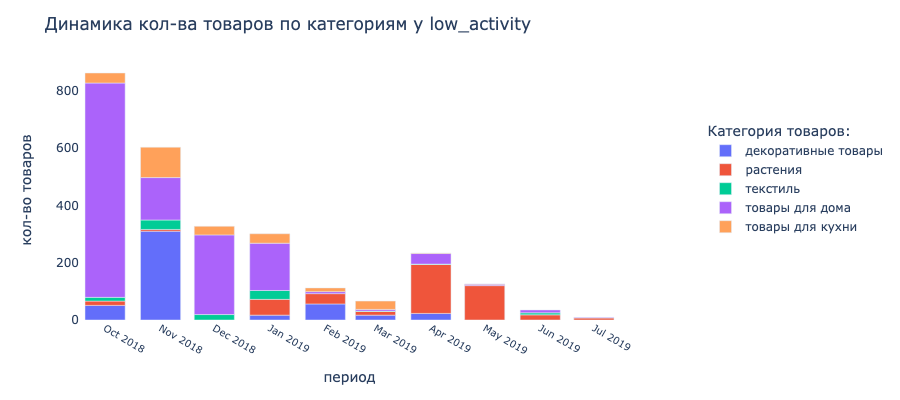

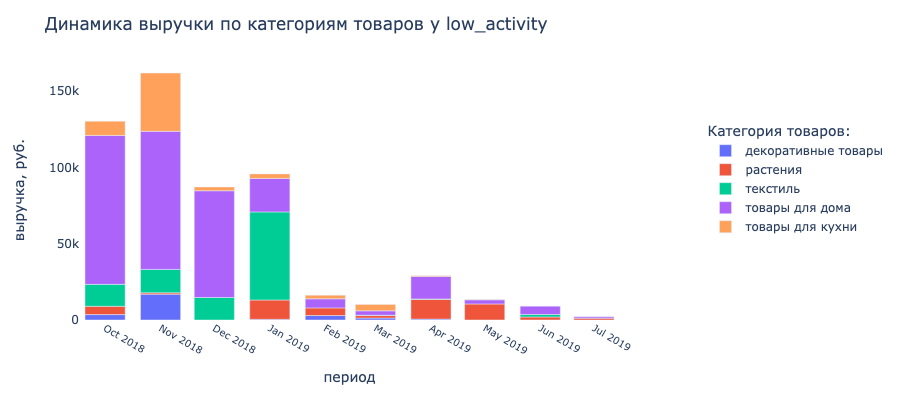

In [38]:
# изучение сезонности покупки товаров у low_activity
low_activity_by_month = low_activity_data.groupby(['year_month','category_2'],as_index = False).agg(
    {'order_id':'nunique','quantity':'sum','total_price':'sum' })
low_activity_by_month.columns = ['date','category', 'orders', 'quantity','revenue']
# визуализация динамики кол-ва товаров по категориям
fig = px.bar(low_activity_by_month, x='date', y='quantity',  color='category')
fig.update_xaxes(tickangle=30, dtick="M1", tickfont=dict(size=10))
fig.update_layout(
    width=900, height=400,
    title="Динамика кол-ва товаров по категориям у low_activity",
    xaxis_title="период",
    yaxis_title="кол-во товаров",
    font=dict(size=12),
    plot_bgcolor = "rgba(0,0,0,0)",
    legend_title_text='Категория товаров:',
    legend = dict(yanchor="bottom",  y= 0.3 , xanchor="right", x= 1.5 ) )
fig.show(renderer='png', width = 900, height = 400)
# визуализация динамими выручки по категориям
fig = px.bar(low_activity_by_month, x='date', y='revenue',  color='category')
fig.update_xaxes(tickangle=30, dtick="M1", tickfont=dict(size=10))
fig.update_layout(
    width=900, height=400,
    title="Динамика выручки по категориям товаров у low_activity",
    xaxis_title="период",
    yaxis_title="выручка, руб.",
    font=dict(size=12),
    plot_bgcolor = "rgba(0,0,0,0)",
    legend_title_text='Категория товаров:',
    legend = dict(yanchor="bottom",  y= 0.3 , xanchor="right", x= 1.5 ) )
fig.show(renderer='png', width = 900, height = 400)

<b>Выводы по предпочтениям сегмента "покупатели с низкой активностью" (low_activity):</b> <br>
<br>
ТОП-3 популярных категорий товаров (доля купленных товаров, %):<br>
-Товары для дома 53%<br>
-Декоративные товары 18%<br>
-Растения 16%<br>
<br>
Сезонность: <br>
-Товары для дома: активно покупают во все месяцы<br>
-Растения: покупают в январе, апреле и мае  <br>
-Декоративные товары, Товары для кухни и Текстиль: нет четко выраженной сезонности (разовые покупки)<br>
<br>
Средняя стоимость купленного товара по категориям: <br>
-Текстиль: 992 руб.<br>
-Товары для кухни: 241 руб.<br>
-Товары для дома: 222 руб.<br>
-Растения:  119 руб.<br>
-Декоративные товары: 54 руб.<br>

<div style="border:solid lightblue 2px; padding: 5px">
<b>Вывод по разделу №5 проекта:</b> <br>
Были проанализированы предпочтения в товарах и сезонность покупок по 4-м сегментам: наблюдается отличия в профилях покупок сегментов. <br>
Для сегмента "неактивные клиенты" (lost_clients) не проведен анализ предпочтений, так как вероятность возврата данных клиентов крайне мала.<br>
Детальтные рекомендации по сегментам приведены в разделе №6 (Общий вывод).    <br>

### Общий вывод

<br>
1. На основании проведенного анализа были выявлены профили покупателей и найдены их предпочтения.<br>
Краткое описание профилей покупателей по сегментам:<br>
<br>
<b>Сегмент "вип-клиенты" (vip_clients):</b> <br>
Доля сегмента в общем кол-ве покупателей: 8%<br>
Доля сегмента по выручке за период: 43% <br>
Средняя стоимость заказа по сегменту: ~ 5400 руб.<br>
ТОП-3 популярных категорий товаров (доля купленных товаров, %): Товары для дома 58% / Растения 17% / Декоративные товары 11%<br>
Сезонность: <br>
-Товары для дома: активнов покупают во все месяцы<br>
-Растения: покупают с апреля по июнь  <br>
-Декоративные товары, Товары для кухни и Текстиль - нет четко выраженной сезонности (разовые покупки)<br>
<br>
<b>Сегмент "активные высокодоходные" (active_high_income):</b> <br>
Доля сегмента в общем кол-ве покупателей: 21%<br>
Доля сегмента по выручке за период: 19% <br>
Средняя стоимость заказа по сегменту: ~ 1600 руб.<br>
ТОП-3 популярных категорий товаров (доля купленных товаров, %): Товары для дома 45% / Растения 27% / Декоративные товары 13%<br>
Сезонность: <br>
-Товары для дома, Растения, Текстиль, Товары для кухни: активно покупают во все месяцы<br>
-Декоративные товары: нет четко выраженной сезонности (разовые покупки)<br>
<br>
<b>Сегмент "активные низкодоходные" (active_low_income):</b> <br>
Доля сегмента в общем кол-ве покупателей: 24%<br>
Доля сегмента по выручке за период: 5% <br>
Средняя стоимость заказа по сегменту: ~ 400 руб.<br>
ТОП-3 популярных категорий товаров (доля купленных товаров, %): Растения 35% / Товары для дома 31% / Декоративные товары 21%<br>
Сезонность: <br>
-Товары для дома, Растения, Товары для кухни и Декоративные товары: активно покупают во все месяцы<br>
-Текстиль: нет четко выраженной сезонности (разовые покупки)<br>
<br>
<b>Сегмент "покупатели с низкой активностью" (low_activity):</b> <br>
Доля сегмента в общем кол-ве покупателей: 5%<br>
Доля сегмента по выручке за период: 12% <br>
Средняя стоимость заказа по сегменту: ~ 2350 руб.<br>
ТОП-3 популярных категорий товаров (доля купленных товаров, %): Товары для дома 53% / Декоративные товары 18% / Растения 16%<br>
Сезонность: <br>
-Товары для дома: активно покупают во все месяцы<br>
-Растения: покупают в январе, апреле и мае  <br>
-Декоративные товары, Товары для кухни и Текстиль: нет четко выраженной сезонности (разовые покупки)<br>
<br>
<b>Сегмент "неактивные покупатели" (lost_clients):</b> <br>
Доля сегмента в общем кол-ве покупателей: 43%<br>
Доля сегмента по выручке за период: 20% <br>
Средняя стоимость заказа по сегменту: ~ 900 руб.<br>
Детальные предпочтения по сегменту не рассматривались, так как вероятность их возвращения в магазин крайне мала (последняя покупка была болше года назад и не более 2х заказов или совершили более 212 дней назад всего 1 заказ, выручка средняя и ниже).<br>
<br>
2. Цели по маркетинговым активносям для сегментов:<br>
- "вип-клиенты"  - удерживать любыми способами <br>
- "активные высокодоходные" - увеличение кол-ва повторных заказов / кол-ва товаров в заказе, так как сегмент платежеспособный <br>
- "активные низкодоходные" - увеличение среднего чека (в том числе за счет продажи нескольких недорогих товаров, например, акции "2 + 1")<br>
- "покупатели с низкой активностью" - постараться вернуть их к повторой покупке (направить несколько маркетинговых активностей)<br>
- "неактивные покупатели" не направлять маркетинговые активности, вероятность их возвращения в магазин крайне мала<br>
<br>
3. Рекомендации по маркетинговым активносям для сегментов:<br>
- для сегмента "вип-клиенты" (vip_clients) можно проводить дорогие индивидуальные маркетинговые активности: средняя стоимость заказа сегмента 5400 руб.<br>
- для сегмента "активные высокодоходные" (active_high_income) можно активно проводить маркетинговые активности: средняя стоимость заказа  сегмента 1600 руб.<br>
- для сегмента "активные низкодоходные" (active_low_income) можно проводить только недорогие маркетинговые активности: средняя стоимость заказа сегмента 400 руб.<br>
- направить дорогие и активные маркетинговые активности на сегмент "покупатели с низкой активностью" (low_activity), так как пользователи данного сегмента имеют высокую потенциальную доходность (потенциально принесут заказ в 2350 руб.)<br>
<br>
4. Рекомендации по товарным предложениям для сегментов:<br>
- для сегмента "вип-клиенты" (vip_clients): "Товары для дома" в любое время года и "Растения" с апреля по июнь <br>
- для сегмента "активные высокодоходные" (active_high_income): "Товары для дома" и "Растения" в любое время года <br>
- для сегмента "активные низкодоходные" (active_low_income): "Товары для дома" и "Растения" и "Декоративные товары" в любое время года <br>
- для сегмента "покупатели с низкой активностью" (low_activity): "Товары для дома" в любое время года и "Растения" с апреля по май <br>